import modules

In [1]:
# @title import modules
import torch as t
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import imageio
from IPython.display import Image
from IPython import display
import time
from typing import Tuple, List
from model import model
from likelihoods import spread_likelihood, transition_likelihood, total_likelihood, neg_log_likelihood
from risk_conv import risk_convolution2D
from model import init_grids, model
from utils import chop_and_shuffle_data
from vis_utils import visualize_sequence

c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Gradient-based learning of $\beta$ using the likelihood of the transitions

## Finding the likelihood of a transition

Through a series of differentiable transformations, we can calculate the total likelihood of transitioning from a given input state $x_t$ to an output state $x_{t+1}$, for a given $\beta$ value. In the following, a quick overview of the transformations is provided using an example transition:

$$
x_t = \begin{pmatrix}
0 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0 
\end{pmatrix}, 
x_{t+1} = \begin{pmatrix}
0 & 1 & 0 \\
0 & 1 & 0 \\
0 & 1 & 1 
\end{pmatrix},
\beta = 0.1
$$

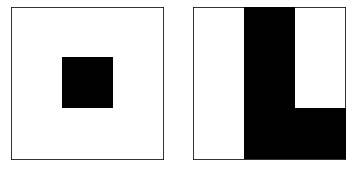

In [8]:
# Define the two grids
x_t = t.zeros((1,3,3))
x_t[0,1,1] = 1
x_tt = t.zeros((1,3,3))
x_tt[0,1,1] = 1.
x_tt[0,2,1] = 1.
x_tt[0,2,2] = 1.
x_tt[0,0,1] = 1.

# Visualize the grids
fig, axs = plt.subplots(1,2)
axs[0].imshow(x_t[0], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
axs[0].get_xaxis().set_visible(False)
axs[0].get_yaxis().set_visible(False)
axs[1].imshow(x_tt[0], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
axs[1].get_xaxis().set_visible(False)
axs[1].get_yaxis().set_visible(False)

### 1. Get the amount of active neighbors for each cell in $x_t$

$$
Y= \begin{pmatrix}
1 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 1 
\end{pmatrix} \circledast x_t
$$

In [11]:
risk_convolution2D(x_t)

tensor([[[[1., 1., 1.],
          [1., 0., 1.],
          [1., 1., 1.]]]])

### 2. Determine the likelihood of spread for each cell in $x_t$ based on the number of active neighbors and $\beta$

$$
L = \begin{pmatrix}
1-(1-\beta)^{Y_{11}} & \dots & 1-(1-\beta)^{Y_{k1}} \\
\dots & \dots & \dots \\
1-(1-\beta)^{Y_{1k}} & \dots & 1-(1-\beta)^{Y_{kk}} 
\end{pmatrix}
$$

NOTE: Here, we do not take into account the current state of the cells in $x_t$ yet.

In [13]:
L = spread_likelihood(x_t, t.tensor(0.1))
print(L)

tensor([[[0.1000, 0.1000, 0.1000],
         [0.1000, 0.0000, 0.1000],
         [0.1000, 0.1000, 0.1000]]])


### 3. Account for the input state of the cells in $x_t$ and the output state of the cells in $x_{t+1}$

There are three cases to consider. Cells can transition from:

- **A:** state 0 to state 1, e.g. cell $(0,1)$. The probability of this transition is given by $L_{01}$
- **B:** state 0 to state 0, e.g. cell $(0,0)$. The probanility of this transition is given by $(1-L_{00})$
- **C:** state 1 to state 0, e.g. cell $(1,1)$. The probability of this is 1 by construction

To capture this in a single function, we use:

$$P = (1 - x_t) \odot (1 - x_{t+1}) \odot (1 - L) + (x_{t+1} \odot L \odot (1 - x_t)) + x_t$$

where $\odot$ stands for element-wise multiplication.

The function can be broken down into three pieces that get added up:

1. $(1 - x_t) \odot (1 - x_{t+1}) \odot (1 - L)$:

This covers scenario **B**. If a cell is active at either $t$ or $t+1$, this evaluates to $0$.

2. $(x_{t+1} \odot L \odot (1 - x_t))$

This covers scenario **A**. If a cell $ij$ is inactive at time $t$ and becomes active at $t+1$, it evaluates to $L_{ij}$, else 0.

3. $x_t$:

This covers scenario **C**. If a cell was already active at time $t$, this evaluates to 1

In [15]:
P = transition_likelihood(L, x_t, x_tt)
print(P)

tensor([[[0.9000, 0.1000, 0.9000],
         [0.9000, 1.0000, 0.9000],
         [0.9000, 0.1000, 0.1000]]])


### 4. Determine the total likelihood

$P$ gives us a matrix where each entry $ij$ corresponds to the likelihood of transitioning from $x_t^{ij}$ to $x_{t+1}^{ij}$ given beta. To get the total likelihood of the transition, we need to calculate the product of all entries. For our example, this likelihood should come out to $\approx 0.0006$

In [17]:
likelihood = total_likelihood(P)
print(likelihood)

tensor(0.0006)


## Finding the gradient of the likelihood

We use pytorch to calculate the gradient of the likelihood w.r.t. $\beta$. The following code visualizes the likelihood and gradient depending on the value of beta for our toy example:

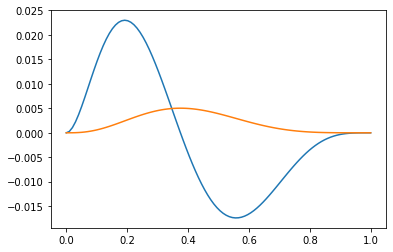

In [19]:
# define a range of beta values
betas = t.linspace(0,1,100)
# start collecting the gradients
gradients = []
# start collecting the likelihoods
tot_likelihoods = []
# iterate over each beta value
for beta in betas:
    # start tracking the computational graph of beta for the gradient
    beta.requires_grad_()
    # calculate the spread likelihood for the given beta
    l = spread_likelihood(x_t, beta)
    # calculate the transition likelihood matrix for the given beta
    p = transition_likelihood(l, x_t, x_tt)
    # calculate the total likelihood of the transition
    tot_likelihood = total_likelihood(p)
    # use pytorch autograd to find the gradient of the tot. likelihood w.r.t beta
    gradient = t.autograd.grad(tot_likelihood, beta)[0]
    # collect the values
    gradients.append(gradient.detach().numpy())
    tot_likelihoods.append(tot_likelihood.detach().numpy())

# visualize
plt.plot(betas, gradients, label="grd w.r.t. p")
plt.plot(betas, tot_likelihoods, label="likelihood")

## Defining a training loop to optimize beta

We now want to define a method that takes in a value for $\beta$ and uses the gradient w.r.t. the likelihood in order to get us a 'better' value for beta. The following defines a very simple function for that:

In [41]:
def update(beta:t.Tensor, x_t:t.Tensor, x_tt:t.Tensor, learning_rate:float) -> t.Tensor:
    beta.requires_grad_()
    # calculate the spread likelihood for the given beta
    L = spread_likelihood(x_t, beta)
    # calculate the transition likelihood matrix for the given beta
    P = transition_likelihood(L, x_t, x_tt)
    # calculate the total likelihood of the transition
    tot_likelihood = total_likelihood(P)
    # use pytorch autograd to find the gradient of the tot. likelihood w.r.t beta
    gradient = t.autograd.grad(tot_likelihood, beta)[0]
    return beta + learning_rate * gradient

We can now use this function to find the maximum likelihood estimate for $\beta$ in our toy example. For the example, we can also easily find the maximum likelihood estimate analytically. This allows us to check if our method converges correctly.

Every cell around the center has 1 active neighbor, reducing the probability for activation to $1-(1-\beta)^1=\beta$. This means, that every cell transitions with probability $\beta$ from inactive to active with exception of the center itself. In our example, 3 out of 8 cells transition to the active state. This is equivalent to stating that out of 8 independent bernoull trials, 3 were successful. The maximum likelihood estimate for $\beta$ is hence $\frac{3}{8}=0.375$. 

In [32]:
beta = t.tensor(0.5)
num_training_steps = 100

for i in range(1000):
  #print(f"Gradient {grad(total_likelihood, argnums=2)(x_t,x_tt,beta)}")
  beta = update(beta, x_t, x_tt, 0.1)
  #print(f"updated beta: {beta}")
print(f"Final Beta: {beta}")

Final Beta: 0.37500086426734924


### Exercise 1

**Objective:** Find the parameter $\beta$ that maximizes the likelihood of the sample transition:

$$
x_t = \begin{pmatrix}
0 & 1 & 0 \\
0 & 1 & 0 \\
0 & 1 & 0 
\end{pmatrix}, 
x_{t+1} = \begin{pmatrix}
1 & 1 & 0 \\
1 & 1 & 0 \\
0 & 1 & 1 
\end{pmatrix}
$$

The risk convolution $Y$ here is given as:

$$Y = 
\begin{pmatrix}
1 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 1 
\end{pmatrix} \circledast x
=
\begin{pmatrix}
1 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 1 
\end{pmatrix} \circledast 
\begin{pmatrix}
0 & 1 & 0 \\
0 & 1 & 0 \\
0 & 1 & 0 
\end{pmatrix}
= 
\begin{pmatrix}
3 & 2 & 3 \\
3 & 2 & 3 \\
3 & 2 & 3 
\end{pmatrix}
$$

We note, that the cells on the center vertical line were all active in $x_t$. Hence, they can be disregarded. The other 6 cells all have 3 active neighbors each. Their respective transition likelihood is given by:

$$
P(x_{ij}=1) = 1-(1-\beta)^3
$$
$$
= 1- 1 - 3 \beta + 3 \beta^2 - \beta^3
$$
$$
= -3\beta+3\beta^2-\beta^3
$$

Three out of the six trials are successful, giving us an empirical probability of $0.5$. It follows that:

$$
0.5 = -3\beta+3\beta^2-\beta^3 \approx 0.206299
$$

We can again show, that the gradient-based approach converges to this value for beta:

In [47]:
x_t = t.zeros((1,3,3))
x_t[0,:,1] = 1

x_tt = t.zeros((1,3,3))
x_tt[0,:,1] = 1
x_tt[0,0,0] = 1
x_tt[0,1,0] = 1
x_tt[0,2,2] = 1

def train(x_t, x_tt, beta, lr=0.01, num_steps=10_000):
  for i in range(num_steps):
    beta = update(beta, x_t, x_tt, lr)
  return beta

betas = t.linspace(0.01,0.99,20)
for beta in betas:
  final_beta = train(x_t, x_tt, beta)
  print(f"started with beta={beta:.6f} - after 10_000 gradient steps beta={final_beta:.6f}")

started with beta=0.010000 - after 10_000 gradient steps beta=0.206299
started with beta=0.061579 - after 10_000 gradient steps beta=0.206299
started with beta=0.113158 - after 10_000 gradient steps beta=0.206299
started with beta=0.164737 - after 10_000 gradient steps beta=0.206299
started with beta=0.216316 - after 10_000 gradient steps beta=0.206300
started with beta=0.267895 - after 10_000 gradient steps beta=0.206300
started with beta=0.319474 - after 10_000 gradient steps beta=0.206300
started with beta=0.371053 - after 10_000 gradient steps beta=0.206300
started with beta=0.422632 - after 10_000 gradient steps beta=0.206300
started with beta=0.474211 - after 10_000 gradient steps beta=0.206300
started with beta=0.525789 - after 10_000 gradient steps beta=0.206300
started with beta=0.577368 - after 10_000 gradient steps beta=0.206300
started with beta=0.628947 - after 10_000 gradient steps beta=0.206300
started with beta=0.680526 - after 10_000 gradient steps beta=0.206300
starte

We note that as the initial guess deviates too far from the MLE of $\beta$, the 10_000 steps with the chosen learning rate are not enough to converge to the right solution. Here, we would need to choose a higher learning rate or take (many) more gradient steps.

### Exercise 2

We consider another example transition of the form:

$$
x_t = \begin{pmatrix}
0 & 0 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 & 0\\
0 & 1 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0
\end{pmatrix}, 
x_{t+1} = \begin{pmatrix}
1 & 0 & 0 & 0 & 0 \\
1 & 1 & 1 & 0 & 0 \\
1 & 1 & 1 & 0 & 0\\
0 & 1 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0
\end{pmatrix}
$$

applying a periodic Torus padding to $x_t$ gives us the following $7\times7$ matrix:

$$
\left[\begin{array}{c|ccccc|c} 
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\hline
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 1 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\hline
0 & 0 & 0 & 0 & 0 & 0 & 0
\end{array}\right]
$$

We get a risk matrix Y of:

$$
Y = 
\begin{pmatrix}
1 & 1 & 0 & 0 & 1 \\
1 & 3 & 2 & 1 & 1 \\
2 & 2 & 1 & 1 & 1\\
1 & 2 & 2 & 1 & 0\\
0 & 0 & 0 & 0 & 0
\end{pmatrix}
$$

We find 11 entries with one active neighbor, respectively. Two of these are active themselves, removing them from consideration. Hence, it remains that we have 9 bernoulli trials with probability $\beta$, of which 2 is successful.

Further, we find 5 entries with two active neighbors, respectively. One of them is active at time $t$, leaving us with 4 bernoulli trials of probability $\beta^2-2\beta$. Out of these, 3 were successful.

Finally, there is one successful trial with 3 active neighbors.

We can write the total likelihood of this event as a bernoulli chain of form:

$$
\beta^2(1-\beta)^7(1-(1-\beta)^2)^3(1-\beta)^2(1-(1-\beta)^3)
$$

We can now use the gradient-based to find the beta, for which this transition is maximally likely, by setting:

$$
\frac{\partial}{\partial \beta}[\beta^2(1-\beta)^7(1-(1-\beta)^2)^3(1-\beta)^2(1-(1-\beta)^3)]=0
$$

We expect our approach to converge towards $\beta \approx 0.35519$


In [56]:
x_t = t.zeros((1,5,5))
x_t[0,2,2] = 1.
x_t[0,2,1] = 1.
x_t[0,1,0] = 1.

x_tt = t.zeros((1,5,5))
x_tt[0,0,0] = 1.
x_tt[0,1,1] = 1
x_tt[0,2,2] = 1
x_tt[0,1,2] = 1
x_tt[0,2,1] = 1
x_tt[0,2,0] = 1
x_tt[0,1,2] = 1
x_tt[0,1,0] = 1
x_tt[0,3,1] = 1
x_tt[0,3,3] = 1

def train(x_t, x_tt, beta, lr=0.01, num_steps=1000, verbose=False):
  for i in range(num_steps):
    beta = update(beta, x_t, x_tt, lr)
    if verbose and i % 500 == 0:
      print(f"beta after step {i}: {beta}")
  return beta

beta = t.tensor(0.2)

result = train(x_t, x_tt, beta, num_steps=5_000, lr=0.1, verbose=True)
print(f"beta after optimization: {result}")

beta after step 0: 0.2001957893371582
beta after step 500: 0.2970249354839325
beta after step 1000: 0.3387461006641388
beta after step 1500: 0.3505529463291168
beta after step 2000: 0.35386916995048523
beta after step 2500: 0.354810506105423
beta after step 3000: 0.3550785779953003
beta after step 3500: 0.3551552891731262
beta after step 4000: 0.3551766574382782
beta after step 4500: 0.3551798462867737
beta after optimization: 0.3551798462867737


## Learning $\beta$ for a dataset of state transitions

In the very most cases, we want to learn $\beta$ for not just one transition, but for a large set of observed transitions. We can use the same approach as before for this and maximize the likelihood of the dataset. However, to do this accurately we would have to take the product of the likelihoods for each transition. This would result in a vanishingly small total likelihood.

Instead, we can optimize the sum of the negative log likelihoods of the samples. This is equivalent to omptimizing the product of the likelihoods.

### Generating a dataset

In [2]:
grid_size = 9
beta = t.tensor(0.08)
num_sequences = 100 
steps_per_sequence = 20
sequences = t.zeros((num_sequences, steps_per_sequence, grid_size, grid_size))

In [ ]:
batch = init_grids(grid_size, num_sequences)

for i in range(steps_per_sequence):
  sequences[:,i,:,:] = batch.detach().clone()
  batch = model(batch, beta)

visualize_sequence(sequences[t.randint(num_sequences, size=(1,))].squeeze(0), framerate=0.2)
dataset = chop_and_shuffle_data(sequences)

In [5]:
dataset.size()

torch.Size([1900, 2, 9, 9])

### Define the training loop

In [9]:
def update(beta:t.Tensor, x_t:t.Tensor, x_tt:t.Tensor, learning_rate:float) -> t.Tensor:
    beta.requires_grad_()
    # calculate the spread likelihood for the given beta
    L = spread_likelihood(x_t, beta)
    # calculate the transition likelihood matrix for the given beta
    P = transition_likelihood(L, x_t, x_tt)
    # calculate the total likelihood of the transition
    neg_log_l = neg_log_likelihood(P)
    # use pytorch autograd to find the gradient of the tot. likelihood w.r.t beta
    gradient = t.autograd.grad(neg_log_l, beta)[0]
    return beta - learning_rate * gradient, neg_log_l

In [12]:
def train(x_t:np.ndarray, x_tt:np.ndarray, beta:float, lr=0.01, num_steps=1000, verbose=False):
  """
  Execute the training loop.
  """
  betas = []
  grad_steps = []
  likelihoods = []
  for i in range(num_steps):
    beta, log_likelihood = update(beta, x_t, x_tt, lr)
    likelihoods.append(log_likelihood.detach().numpy())
    betas.append(beta.detach().numpy())
    if verbose and i % 100 == 0:
      print(f"beta after step {i}: {beta}")
  return beta, betas, likelihoods

starting with beta=tensor([0.0523])
Final Beta: tensor([0.0787], grad_fn=<SubBackward0>)


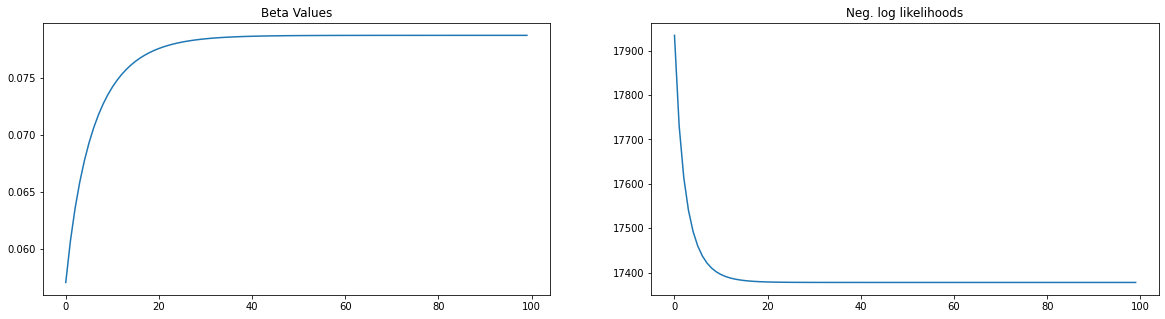

In [16]:
beta = t.rand(1)
x_t = dataset[:,0,:,:]
x_tt = dataset[:,1,:,:]

print(f"starting with beta={beta}")

result, beta_hist, likelihoods = train(x_t, x_tt, beta, lr=1e-7, num_steps=100)

fig, axs = plt.subplots(1,2,figsize=(20,5))
axs[0].plot(np.arange(len(beta_hist)), beta_hist, label="beta")
axs[0].set_title('Beta Values')
axs[1].plot(np.arange(len(beta_hist)), likelihoods, label="neg. log likelihoods")
axs[1].set_title('Neg. log likelihoods')

print(f"Final Beta: {result}")

[Text(0.5, 0, 'beta'), Text(0, 0.5, 'neg. log likelihood'), (0.0, 0.2)]

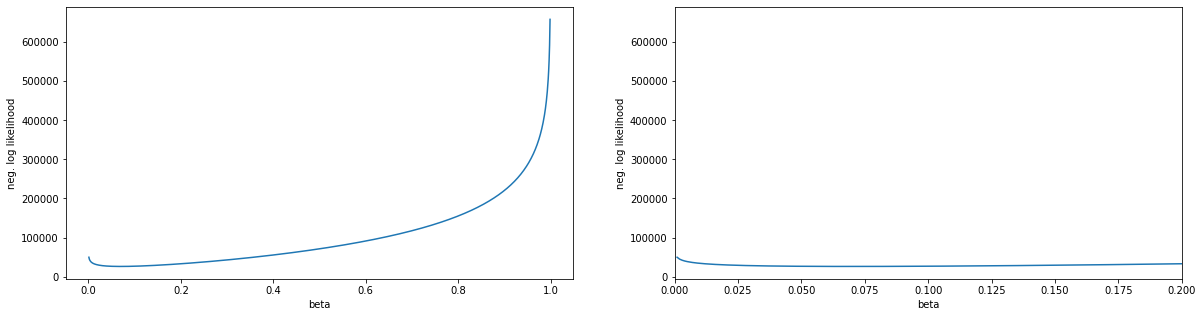

In [21]:
betas = t.linspace(0,1,1000)
neg_log_likelihoods = []
for beta in betas:
    L = spread_likelihood(x_t, beta)
    P = transition_likelihood(beta, x_t, x_tt)
    neg_log_likelihoods.append(neg_log_likelihood(P).detach().numpy())

fig, axs = plt.subplots(1,2,figsize=(20,5))
axs[0].plot(betas, neg_log_likelihoods)
axs[0].set(xlabel="beta", ylabel="neg. log likelihood")
axs[1].plot(betas, neg_log_likelihoods)
axs[1].set(xlabel="beta", ylabel="neg. log likelihood", xlim=(0,0.2))